In [1]:
import sys
sys.path.append('..')
from pymavlink import mavutil
import matplotlib.pyplot as plt
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point, LineString

from sqlalchemy import create_engine

from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import POSTGRES_UTEA

RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

def obtener_engine():
    return create_engine(
        f"postgresql+psycopg2://{POSTGRES_UTEA['USER']}:{POSTGRES_UTEA['PASSWORD']}@{POSTGRES_UTEA['HOST']}:{POSTGRES_UTEA['PORT']}/{POSTGRES_UTEA['DATABASE']}"
    )

In [21]:
vehiculo = 'DA01'

In [22]:
if vehiculo == 'DA01':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_01'
elif vehiculo == 'DA02':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_02'
elif vehiculo == 'DA03':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_03'
contenido = os.listdir(path_log)
len(contenido)

188

In [23]:
gdf_rec = gpd.read_postgis(
    "SELECT * FROM drones_control_bio.recorridos_lib", 
    obtener_engine(), 
    geom_col='geom'  # columna con la geometría
)

In [24]:
gdf_rec.head()

,id,geom,idd,nombre,vehiculo,num_vert,asignado
0,1,"MULTILINESTRING ((471873.745 8084797.248, 4718...",-1,2025-05-02 08-32-28.tlog,DA02,2517.0,ORIGINAL
1,2,"MULTILINESTRING ((478886.299 8093597.535, 4788...",-1,2025-05-05 16-16-47.tlog,DA02,1056.0,ORIGINAL
2,247,"MULTILINESTRING ((474276.861 8075803.608, 4742...",616,2025-08-12 03-00-11.tlog,DA02,1710.0,None
3,248,"MULTILINESTRING ((473445.600 8076788.235, 4734...",616,2025-08-12 03-45-43.tlog,DA02,1605.0,None
4,249,"MULTILINESTRING ((469649.803 8090516.827, 4696...",617,2025-08-12 04-25-58.tlog,DA02,1988.0,None


In [25]:
# Filtrar la lista 'contenido' para excluir elementos que están en la columna 'nombre' del GeoDataFrame
contenido_filtrado = [item for item in contenido if item not in gdf_rec['nombre'].values]
len(contenido_filtrado)

4

In [26]:
contenido_filtrado

['2025-09-26 22-09-20.tlog',
 '2025-09-27 01-07-19.tlog',
 '2025-09-27 01-17-47.tlog',
 '2025-09-27 02-21-08.tlog']

In [27]:
def leer_logs(lista_logs):
    list_geo = []
    list_name = []
    for i in lista_logs:
        log = path_log + '/' + i
        
        name = i
        
        mlog = mavutil.mavlink_connection(log)
        lats = []
        lons = []
        while True:
            msg = mlog.recv_match()
            if not msg:
                break
            # Ejemplo de procesamiento de mensaje
            if msg.get_type() == 'GLOBAL_POSITION_INT':
                lat = msg.lat / 1e7  # Latitud en grados
                lon = msg.lon / 1e7  # Longitud en grados
                lats.append(lat)
                lons.append(lon)

        coors = {'lat':lats, 'lon':lons}
        df = pd.DataFrame(coors)
        
        geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
        line = LineString(geometry)
        list_geo.append(line)
        list_name.append(name)
    return (list_geo, list_name)

In [28]:
lineas, names = leer_logs(contenido_filtrado)
lineas

[<LINESTRING (0 0, 0 0, 0 0, -63.167 -17.214, -63.167 -17.214, -63.167 -17.21...>,
 <LINESTRING (-63.17 -17.276, -63.17 -17.276, -63.17 -17.276, -63.17 -17.276,...>,
 <LINESTRING (-63.165 -17.281, -63.165 -17.281, -63.165 -17.281, -63.165 -17....>,
 <LINESTRING (-63.167 -17.284, -63.167 -17.284, -63.167 -17.284, -63.167 -17....>]

In [29]:
# Crear un GeoDataFrame con los LineStrings y sus nombres
gdf_lines = gpd.GeoDataFrame({'nombre': names, 'geometry': lineas}, crs="EPSG:4326")
gdf_lines.head(3)

,nombre,geometry
0,2025-09-26 22-09-20.tlog,"LINESTRING (0.00000 0.00000, 0.00000 0.00000, ..."
1,2025-09-27 01-07-19.tlog,"LINESTRING (-63.16980 -17.27563, -63.16980 -17..."
2,2025-09-27 01-17-47.tlog,"LINESTRING (-63.16482 -17.28099, -63.16482 -17..."


In [30]:
# Función para contar la cantidad de coordenadas en una geometría de tipo LINESTRING
def contar_coordenadas(linea):
    return len(linea.coords)

# Función para dividir y limpiar las líneas
def dividir_y_limpiar_linea(linea):
    puntos = list(linea.coords)
    nuevas_lineas = []
    nueva_linea = []
    
    for punto in puntos:
        if punto != (0, 0):
            nueva_linea.append(punto)
        else:
            if nueva_linea:
                nuevas_lineas.append(LineString(nueva_linea))
                nueva_linea = []
    
    if nueva_linea:
        nuevas_lineas.append(LineString(nueva_linea))
    
    return nuevas_lineas

In [31]:
# Crear una lista para las nuevas líneas y nombres
nuevas_lineas = []
nuevos_nombres = []
for idx, row in gdf_lines.iterrows():
    lineas_divididas = dividir_y_limpiar_linea(row.geometry)
    for linea in lineas_divididas:
        nuevas_lineas.append(linea)
        nuevos_nombres.append(row['nombre'])

In [32]:
# Crear un nuevo GeoDataFrame con las nuevas líneas
gdf_lines = gpd.GeoDataFrame({'nombre': nuevos_nombres, 'geometry': nuevas_lineas}, crs="EPSG:4326")

In [33]:
gdf_lines['num_vert'] = gdf_lines['geometry'].apply(contar_coordenadas)
gdf_lines['vehiculo'] = vehiculo
gdf_lines.head(3)

,nombre,geometry,num_vert,vehiculo
0,2025-09-26 22-09-20.tlog,"LINESTRING (-63.16698 -17.21428, -63.16697 -17...",1392,DA01
1,2025-09-26 22-09-20.tlog,"LINESTRING (-63.14205 -17.16782, -63.14205 -17...",1727,DA01
2,2025-09-26 22-09-20.tlog,"LINESTRING (-63.08554 -17.15796, -63.08556 -17...",2924,DA01


<Axes: >

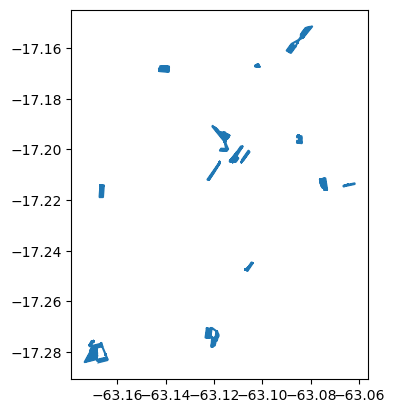

In [34]:
gdf_lines.plot()

In [35]:
gdf_lines.crs = "EPSG:4326"
gdf_lines_utm = gdf_lines.to_crs(epsg=32720)

<Axes: >

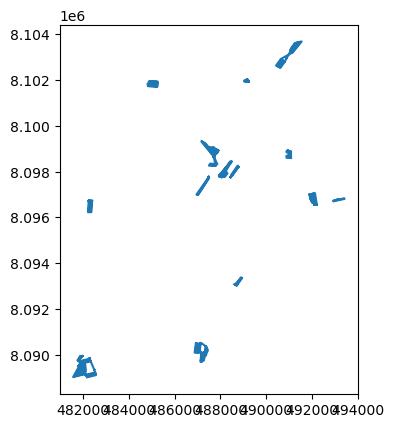

In [36]:
gdf_lines_utm.plot()

In [37]:
gdf_lines_utm['idd'] = 0
gdf_lines_utm = gdf_lines_utm.rename_geometry("geom")

In [38]:
gdf_lines_utm

,nombre,geom,num_vert,vehiculo,idd
0,2025-09-26 22-09-20.tlog,"LINESTRING (482246.483 8096732.822, 482247.058...",1392,DA01,0
1,2025-09-26 22-09-20.tlog,"LINESTRING (484893.343 8101874.463, 484893.353...",1727,DA01,0
2,2025-09-26 22-09-20.tlog,"LINESTRING (490902.005 8102968.358, 490900.282...",2924,DA01,0
3,2025-09-26 22-09-20.tlog,"LINESTRING (489222.836 8101932.016, 489222.815...",801,DA01,0
4,2025-09-26 22-09-20.tlog,"LINESTRING (490955.316 8098926.435, 490955.284...",1388,DA01,0
5,2025-09-26 22-09-20.tlog,"LINESTRING (487700.220 8098656.876, 487700.145...",2884,DA01,0
6,2025-09-26 22-09-20.tlog,"LINESTRING (487493.892 8097765.670, 487493.892...",1604,DA01,0
7,2025-09-26 22-09-20.tlog,"LINESTRING (488444.460 8097759.234, 488445.917...",1174,DA01,0
8,2025-09-26 22-09-20.tlog,"LINESTRING (488062.840 8097762.534, 488062.840...",2094,DA01,0
9,2025-09-27 01-07-19.tlog,"LINESTRING (481952.226 8089945.076, 481952.204...",888,DA01,0


In [39]:
gdf_lines_utm.to_postgis(
    name="recorridos_lib",
    schema="drones_control_bio",
    con=obtener_engine(),
    if_exists="append",   # usa "replace" si quieres sobrescribir todo
    index=False
)